In [2]:
import os
import json
import openslide

import pandas
import numpy as n
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

import PySlide as pys

0.9.0


In [3]:
path = 'images/14.90610 C L2.11.json'
labels = {'GC':0}
file_type = 'json'
keys = ['GC']

In [4]:
ann=pys.Annotations(path, file_type)

In [5]:
annotations = ann.generate_annotations(labels)

### PySlide

In [6]:
slide = pys.Slide('images/14.90610 C L2.11.ndpi',border='draw',annotations=annotations)

In [7]:
slide.save('test.png',(2000,2000))

In [8]:
x = slide.slide_mask((2000,2000))

In [9]:
slide.save('masktest.png',(2000,2000), True)

######NEED TO CHECK WHY MASK IS SQUASHED#######

In [10]:
region, mask = slide.generate_region(mag=4, scale_border=True, factor=256)

x_size:768
y_size:768


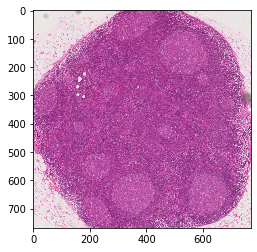

In [11]:
plt.imshow(region)

### Patching

In [12]:
patches = pys.Patching(slide, annotations, mag_level=4)

In [13]:
import time

start_time = time.time()
print(patches.generate_patches(64,'focus'))
print("--- %s seconds ---" % (time.time() - start_time))

37
--- 0.3984701633453369 seconds ---


In [14]:
len(patches.masks)

37

In [15]:
patches.save('images', True)

[Errno 17] File exists: 'images/images'
[Errno 17] File exists: 'images/masks'


In [ ]:
x = openslide.OpenSlide('images/14.90610 C L2.11.ndpi')

In [15]:
patch=x.read_region((12016,25273),4,(256,256))

AttributeError: 'numpy.ndarray' object has no attribute 'read_region'

In [16]:
patch

NameError: name 'patch' is not defined

In [ ]:
12016*16,25273*16

In [38]:
size=int(256*16*.5)
x = int(w-(size*.5))

2048

In [39]:
patch=x.read_region((12016*16,25273*16),4,(256,256))

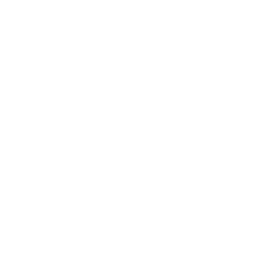

In [40]:
patch

In [43]:
for i in range(0,100):
    print(i*5)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495


In [44]:
patches.slide.dims

(98304, 51968)

In [45]:
256*16

4096

In [ ]:
1

In [20]:
def test():
    for m in range(10):
        yield m

In [22]:
x = test()

In [25]:
for i in range(10):
    print(next(test()))

0
0
0
0
0
0
0
0
0
0


In [16]:
def oneHotToMask(onehot):
    nClasses =  onehot.shape[-1]
    idx = tf.argmax(onehot, axis=-1)
    colors = sns.color_palette('hls', nClasses)
    multimask = tf.gather(colors, idx)
    multimask = np.where(multimask[:,:,:]==colors[0], 0, multimask[:,:,:])
    
    return multimask

In [18]:
import numpy as np

one=np.ones((60,60))
two=np.ones((60,60))*2
three=np.ones((60,60))*3

test=np.hstack([one,two,three])

In [27]:
import tensorflow as tf

colors = sns.color_palette('hls', 3)

np.take_along_axis(test, colors)


#multimask = tf.gather(colors, test)
#multimask = np.where(multimask[:,:,:]==colors[0], 0, multimask[:,:,:])

TypeError: _take_along_axis_dispatcher() missing 1 required positional argument: 'axis'

In [28]:
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.3712, 0.33999999999999997, 0.86)]

In [29]:
colors = sns.color_palette('hls', 3)

